In [4]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [5]:
import datasets

In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow as tf

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tensorflow.keras.utils import to_categorical

In [7]:
dataset_name = "iris"
DS_trn = datasets.load_trn(dataset_name)
DS_tst = datasets.load_tst(dataset_name)
X_train_valid = DS_trn.data
y_train_valid = DS_trn.target
cv_folds = DS_trn.cv_folds
X_test = DS_tst.data
y_test = DS_tst.target

X_train_valid.shape
num_classes = len(np.unique(y_train_valid))


a,b = np.unique(y_train_valid,return_counts=True)


scaler = StandardScaler().fit(X_train_valid)
X_train_valid = scaler.transform(X_train_valid)
X_test = scaler.transform(X_test)

train,valid = cv_folds[0]
y_train_valid = to_categorical(y_train_valid)

X_train = X_train_valid[train,:]
y_train = y_train_valid[train]
X_valid = X_train_valid[valid,:]
y_valid = y_train_valid[valid]

In [8]:
C = 1e2
gamma = 1/(2*C*X_train.shape[0])
batch_size = X_train.shape[0]
# batch_size = 10
initializer = tf.keras.initializers.Zeros()

inputs = keras.Input(shape=(X_train.shape[1],), name="features_in")
logits = layers.Dense(num_classes,
                      activation = "linear",
                      kernel_regularizer=regularizers.l2(gamma),
                      kernel_initializer=initializer,
                      use_bias=False)(inputs)


model = keras.Model(inputs=inputs, outputs=logits)
optimizer = keras.optimizers.SGD(learning_rate=1e-1)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.CategoricalAccuracy()

model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=[accuracy])

print("Accuracy at (random) initialization:",
      np.mean(np.argmax(model(X_test),axis=-1) == y_test))

history = model.fit(X_train,
                    y_train,
                    epochs=300,
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid), 
                    validation_batch_size=X_valid.shape[0],
                    verbose=0)

Accuracy at (random) initialization: 0.35135135135135137


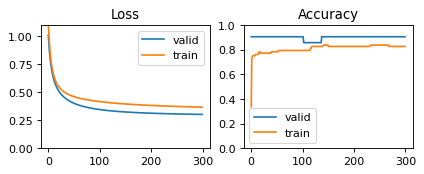

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,2),dpi=80)

ax1.plot(history.history['val_loss'])
ax1.plot(history.history['loss'])
ax1.legend(["valid","train"])
ax1.set_title('Loss')
ax1.set_ylim((0,max(history.history['loss'])))

ax2.plot(history.history['val_categorical_accuracy'])
ax2.plot(history.history['categorical_accuracy'])
ax2.legend(["valid","train"])
ax2.set_title('Accuracy')
ax2.set_ylim((0,1))

plt.show()

In [10]:
print("Test accuracy of converged model:", np.mean(np.argmax(model(X_test),axis=-1) == y_test))

Test accuracy of converged model: 0.8648648648648649
